<a href="https://colab.research.google.com/github/joelsoaresjr/Relatorio_Carteira/blob/main/Relat%C3%B3rio_Carteira.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalar bibliotecas necessárias

In [1]:
!pip install yfinance
!pip install fpdf
!pip install git+https://github.com/quantopian/pyfolio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 2.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

Importanto bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, date
import seaborn as sns
import pyfolio as pf
from scipy.stats import norm
from fpdf import FPDF
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders

/usr/local/lib/python3.8/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


Importar dados

In [3]:
acoes_base=['^BVSP']

nome = input("Digite seu nome:")
hoje = datetime.today()

while True:
  try:
    n_acoes = int(input("Digite o número de ações:"))
    break
  except:
    print("Digite um número inteiro!")

while True:
  try:
    capital = int(input('Digite o valor aplicado:'))
    break
  except:
    print("Digite um número inteiro!")




name_colunas = ["Ibovespa"]

for i in range(0,n_acoes):
    a = input('Digite o ticker da ação número %i:' %(i+1))
    acoes_base.append(a+".SA")
    name_colunas.append(a)

acoes = acoes_base[1:len(acoes_base)]

while True:
  try:
    ano_i=int(input('Digite o ano de início:'))
    mes_i=int(input('Digite o mês de início:'))
    dia_i=int(input('Digite o dia de início:'))
    ano_f=int(input('Digite o ano final:'))
    mes_f=int(input('Digite o mês final:'))
    dia_f=int(input('Digite o dia final:'))
    break
  except:
    print("Digite um número")


start = date(ano_i,mes_i,dia_i)
end = date(ano_f,mes_f,dia_f)


dados = yf.download(acoes_base, start, end)['Adj Close']
dados.columns = name_colunas 

indices_na = dados.loc[dados['Ibovespa'].isna()].index
dados = dados.drop(indices_na)

if 'USDBRL=X' in acoes:
  indices_na_dolar = dados.loc[dados['USDBRL=X'].isna()].index
  dados = dados.drop(indices_na_dolar)


Digite seu nome:Joel
Digite o número de ações:5
Digite o valor aplicado:1000
Digite o ticker da ação número 1:vale3
Digite o ticker da ação número 2:petr4
Digite o ticker da ação número 3:caml3
Digite o ticker da ação número 4:itub4
Digite o ticker da ação número 5:bbas3
Digite o ano de início:2018
Digite o mês de início:1
Digite o dia de início:1
Digite o ano final:2022
Digite o mês final:12
Digite o dia final:31
[*********************100%***********************]  6 of 6 completed


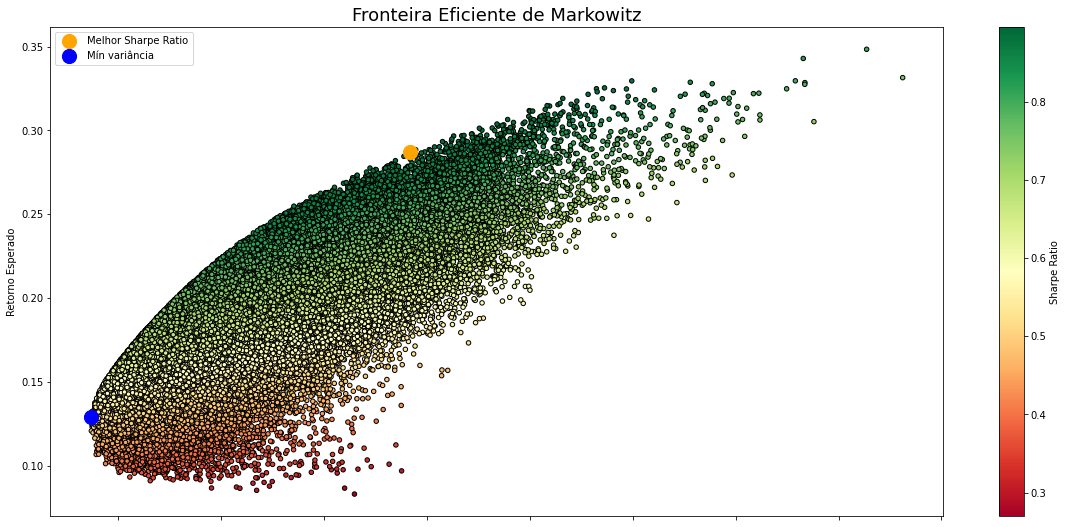

In [4]:
retorno_diario = dados.iloc[:, 1:len(acoes)+1].pct_change()
retorno_anual = retorno_diario.mean() * 250
cov_diaria = retorno_diario.cov()
cov_anual = cov_diaria * 250
retorno_carteira = []
peso_acoes = []
volatilidade_carteira = []
sharpe_ratio = []
numero_acoes = len(acoes) 
numero_carteiras = 100000
np.random.seed(101)

for cada_carteira in range(numero_carteiras):

    peso = np.random.random(numero_acoes)
    peso /= np.sum(peso)
    retorno = np.dot(peso, retorno_anual)

    volatilidade = np.sqrt(np.dot(peso.T, np.dot(cov_anual, peso)))

    sharpe = retorno / volatilidade

    sharpe_ratio.append(sharpe)
    retorno_carteira.append(retorno)
    volatilidade_carteira.append(volatilidade)
    peso_acoes.append(peso)

carteira = {'Retorno': retorno_carteira,
             'Volatilidade': volatilidade_carteira,
             'Sharpe Ratio': sharpe_ratio}

for contar,acao in enumerate(acoes):
    carteira[acao+' Peso'] = [Peso[contar] for Peso in peso_acoes]


df = pd.DataFrame(carteira)

colunas = ['Retorno', 'Volatilidade', 'Sharpe Ratio'] + [acao+' Peso' for acao in acoes]
df = df[colunas]

menor_volatilidade = df['Volatilidade'].min()
maior_sharpe = df['Sharpe Ratio'].max()


carteira_sharpe = df.loc[df['Sharpe Ratio'] == maior_sharpe]
carteira_min_variancia = df.loc[df['Volatilidade'] == menor_volatilidade]



df.plot.scatter(x='Volatilidade', y='Retorno', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(20, 9))
plt.scatter(x=carteira_sharpe['Volatilidade'], y=carteira_sharpe['Retorno'], c='orange', 
            marker='o', s=200, label = 'Melhor Sharpe Ratio')
plt.scatter(x=carteira_min_variancia['Volatilidade'], y=carteira_min_variancia['Retorno'],
            c='blue', marker='o', s=200, label = 'Mín variância')

plt.legend()
plt.xlabel('Volatilidade')
plt.ylabel('Retorno Esperado')
plt.title('Fronteira Eficiente de Markowitz',
          fontsize = 18)
plt.savefig('Fronteira Eficiente de Markowitz', dpi = 200)
     

In [5]:

print ("Essa é a carteira de Mínima Variância:", '\n', carteira_min_variancia.T)
print ('\n')
print ("Essa é a carteira com maior Sharpe Ratio:", '\n', carteira_sharpe.T)

Essa é a carteira de Mínima Variância: 
                   54344
Retorno        0.129067
Volatilidade   0.243414
Sharpe Ratio   0.530234
vale3.SA Peso  0.321337
petr4.SA Peso  0.038103
caml3.SA Peso  0.002266
itub4.SA Peso  0.116353
bbas3.SA Peso  0.521941


Essa é a carteira com maior Sharpe Ratio: 
                     489
Retorno        0.287233
Volatilidade   0.320847
Sharpe Ratio   0.895233
vale3.SA Peso  0.194788
petr4.SA Peso  0.013090
caml3.SA Peso  0.368629
itub4.SA Peso  0.422904
bbas3.SA Peso  0.000589


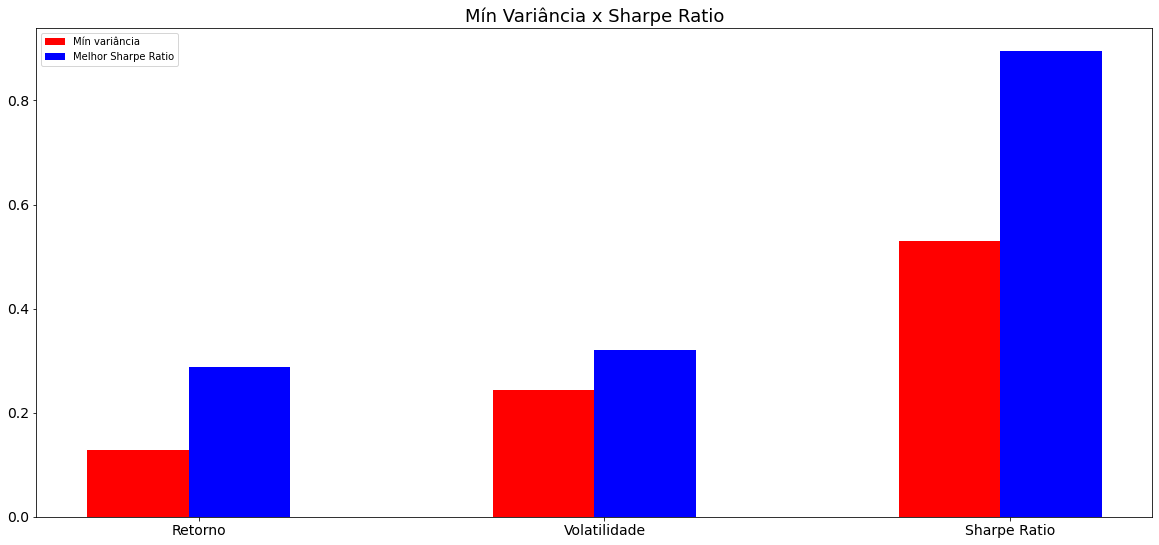

In [6]:
n = np.arange(3)
fig = plt.figure(figsize = (20,9))
plt.bar(n + 0.00, list(carteira_min_variancia.iloc[: , 0:3].values[0]), color = 'red', width = 0.25, label = 'Mín variância')
plt.bar(n + 0.25, list(carteira_sharpe.iloc[: , 0:3].values[0]), color = 'blue', width = 0.25, label = 'Melhor Sharpe Ratio')
plt.title('Mín Variância x Sharpe Ratio',
          fontsize = 18) 
plt.xticks(n + 0.15, ('Retorno', 'Volatilidade', 'Sharpe Ratio'),
           fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend() 
plt.savefig('Mín Variância x Sharpe Ratio', dpi = 200)

Escolha dos pesos

In [7]:
decisao = int(input("Digite 1 para pesos com Min Variância, 2 para melhor Sharpe ou 3 para próprios pesos: "))
if decisao == 1:
    pesos = carteira_min_variancia.iloc[: , 3:].values
    pesoacao = carteira_min_variancia.iloc[: , 3:]
    texto = 'VOCÊ ESCOLHEU PESOS PARA MENOR VOLATILIDADE!'
    print(texto)
elif decisao == 2:
    pesos = carteira_sharpe.iloc[: , 3:].values
    pesoacao = carteira_sharpe.iloc[: , 3:]
    texto = 'VOCÊ ESCOLHEU PESOS PARA MELHOR SHARPE RATIO!'
    print(texto)
else:
    pesos_input=[]
    texto = 'VOCÊ ESCOLHEU DIGITAR OS PESOS MANUALMENTE!'
    print(texto)
    for i in range(len(acoes)):
        p = float(input("Digite o peso, em porcentagem, da %s:" %(acoes[i])))
        pe = p/100
        pesos_input.append(pe)
    pesos = np.array(pesos_input)
     

Digite 1 para pesos com Min Variância, 2 para melhor Sharpe ou 3 para próprios pesos: 2
VOCÊ ESCOLHEU PESOS PARA MELHOR SHARPE RATIO!


Calculado retorno simples e acumulado

In [8]:
dados['Retorno'] = np.dot(dados.iloc[: , 1 : len(acoes) + 1].pct_change(), pesos.T)
dados['Retorno Carteira Acum.'] = (1 + dados['Retorno']).cumprod()
dados['Retorno Carteira Acum.'].iloc [0] = 1 

port_ibov = pd.DataFrame(dados["Ibovespa"].pct_change().iloc[ 1: ])
port_ibov.insert(loc = 1 , column = 'Portifólio', value = dados['Retorno'].iloc[ 1: ])


retorno_portifolio = np.dot(retorno_anual,pesos.T)
retorno_ibov = dados["Ibovespa"].pct_change().mean() * 250


var_mercado_aux = np.log(dados/dados.shift(1))
bov_var = var_mercado_aux["Ibovespa"].var()*250
var_acoes = []
for i in range(len(acoes)):
    var_acoes.append(retorno_diario.iloc[: , i].var()*250)
pfolio_var = np.dot(pesos, np.dot(retorno_diario.cov()*250,pesos.T)) 

pfolio_vol = pfolio_var ** 0.5 


resum_ibov = [retorno_ibov, bov_var**0.5, retorno_ibov/(bov_var**0.5)]
resum_port = [retorno_portifolio[0], pfolio_vol[0][0], retorno_portifolio[0]/pfolio_vol[0][0]]

Gráfico 1

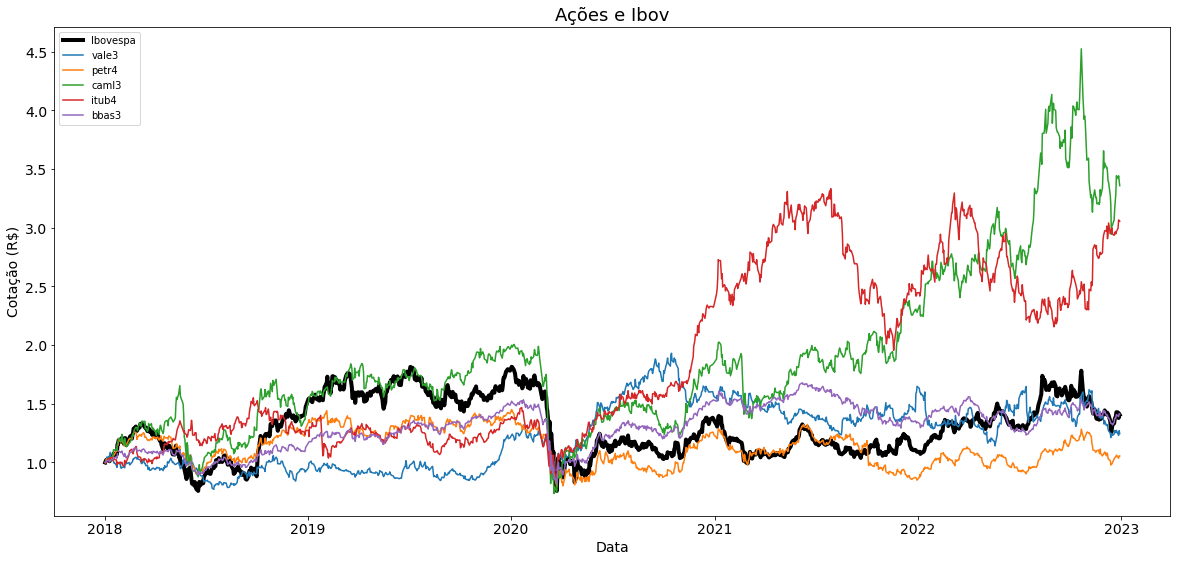

In [9]:
fig1 = plt.figure(figsize = (20,9))
plt.plot((dados.iloc[ : , 0]/dados.iloc[ 0 , 0]), c = 'black', linewidth = 4)
plt.plot(dados.iloc[ : , 1 : len(acoes) + 1]/dados.iloc[ 0 , 1 : len(acoes) + 1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Cotação (R$)",
           fontsize = 14)
plt.xlabel("Data",
           fontsize = 14)
plt.legend(dados.columns)
plt.title('Ações e Ibov',
          fontsize = 18)
plt.savefig('Ações e Ibov', dpi = 200)

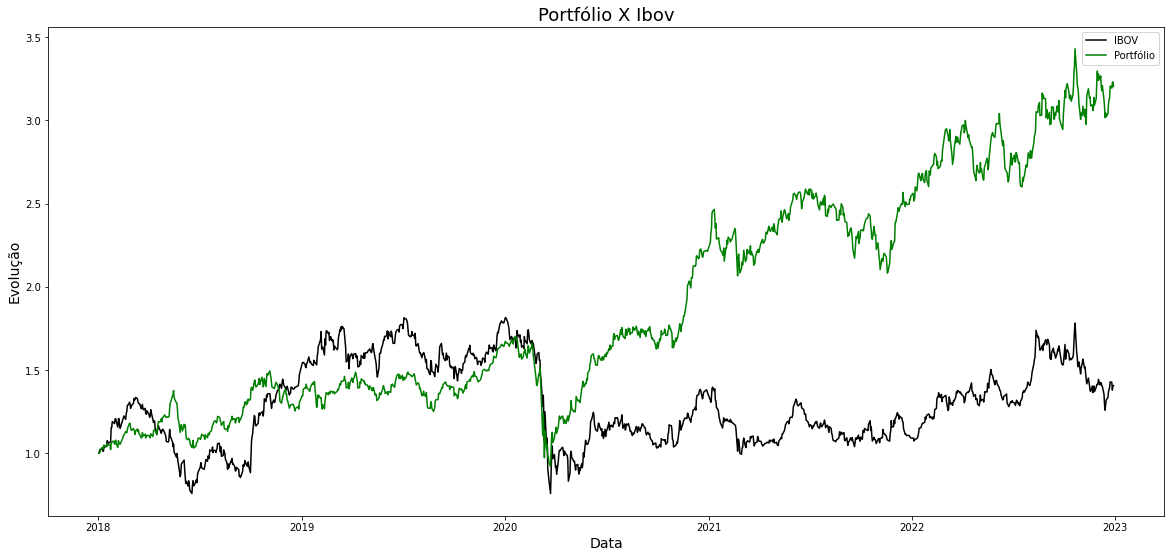

In [10]:
fig3 = plt.figure(figsize = (20,9))

plt.plot(dados.iloc[ : , 0]/dados.iloc[ 0 , 0], label = "IBOV" , c = "Black")
plt.plot(dados['Retorno Carteira Acum.'], label = "Portfólio", c = 'green')
plt.ylabel("Evolução",
           fontsize = 14)
plt.xlabel("Data",
           fontsize = 14)
plt.legend()
plt.title("Portfólio X Ibov",
          fontsize = 18)
plt.savefig('Portfólio X Ibov', dpi = 200)

Gráfico 3

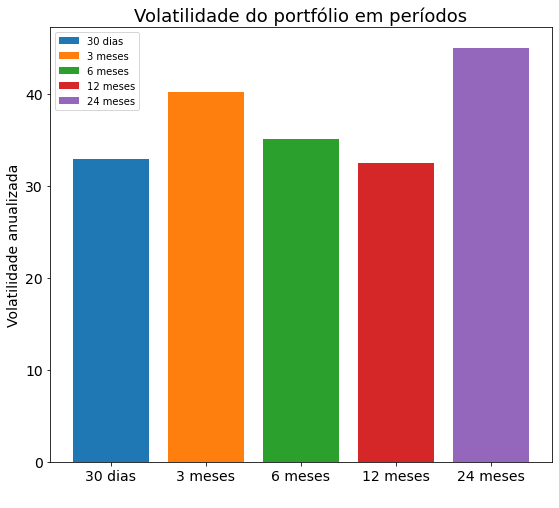

In [11]:
fig4 = plt.figure(figsize = (9,8))


x1 = '30 dias'
plt.bar(x1,port_ibov.iloc[len(port_ibov)-30:len(port_ibov),0].std() *255 ** 0.5 *100, label = x1)
x2 = '3 meses'
plt.bar(x2,port_ibov.iloc[len(port_ibov)-90:len(port_ibov),0].std() *255 ** 0.5 *100, label = x2)
x3 = '6 meses'
plt.bar(x3,port_ibov.iloc[len(port_ibov)-180:len(port_ibov),0].std() *255 ** 0.5 *100, label = x3)
x4 = '12 meses'
plt.bar(x4,port_ibov.iloc[len(port_ibov)-360:len(port_ibov),0].std() *255 ** 0.5 *100, label = x4)
x5 = '24 meses'
plt.bar(x5,port_ibov.iloc[len(port_ibov)-720:len(port_ibov),0].std() *255 ** 0.5 *100, label = x5)

plt.ylabel('Volatilidade anualizada',
           fontsize = 14)
plt.xlabel('  ',
           fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend()
plt.title("Volatilidade do portfólio em períodos",
          fontsize = 18)
plt.savefig('Volatilidade do portfólio em períodos', dpi = 200)

Gráfico 4

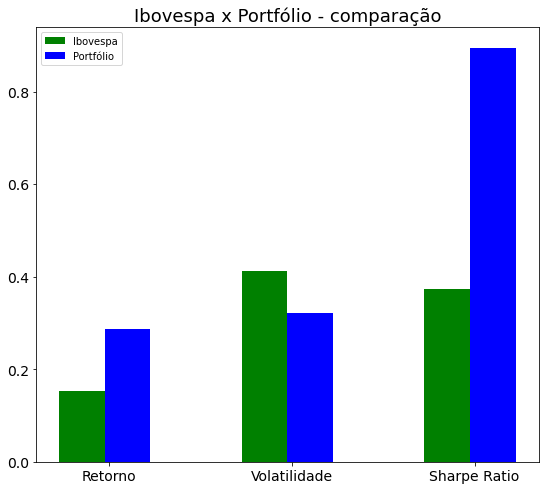

In [12]:
fig5 = plt.figure(figsize = (9,8))

n = np.arange(3)
plt.bar(n + 0.00, resum_ibov, color = 'green', width = 0.25, label = 'Ibovespa')
plt.bar(n + 0.25, resum_port, color = 'blue', width = 0.25, label = 'Portfólio')
plt.title('Ibovespa x Portfólio - comparação',
          fontsize = 18) 
plt.xticks(n + 0.15, ('Retorno', 'Volatilidade', 'Sharpe Ratio'))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend() 
plt.savefig('Ibovespa x Portfólio - comparação', dpi = 200)

Gráfico 5

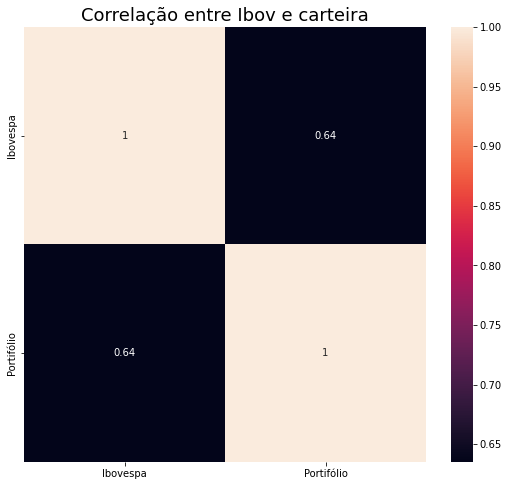

In [13]:
fig6 = plt.figure(figsize = (9,8))

plt.title("Correlação entre Ibov e carteira", fontsize = 18);
matriz_correlação_pfolio_ibov= port_ibov.corr()
matiz_correlacao_acoes_ibov = dados.iloc[ : , 0: len(acoes_base)].corr()

sns.heatmap(matriz_correlação_pfolio_ibov, annot = True)
plt.savefig('Correlação entre Ibov e carteira', dpi = 200)

Gráfico 6

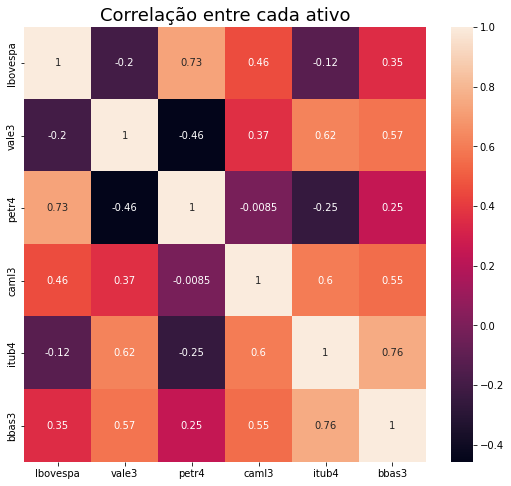

In [14]:
fig7 = plt.figure(figsize = (9,8))


plt.title("Correlação entre cada ativo", fontsize = 18);
sns.heatmap(matiz_correlacao_acoes_ibov, annot = True)
plt.savefig('Correlação entre cada ativo', dpi = 200)

Gráfico 7

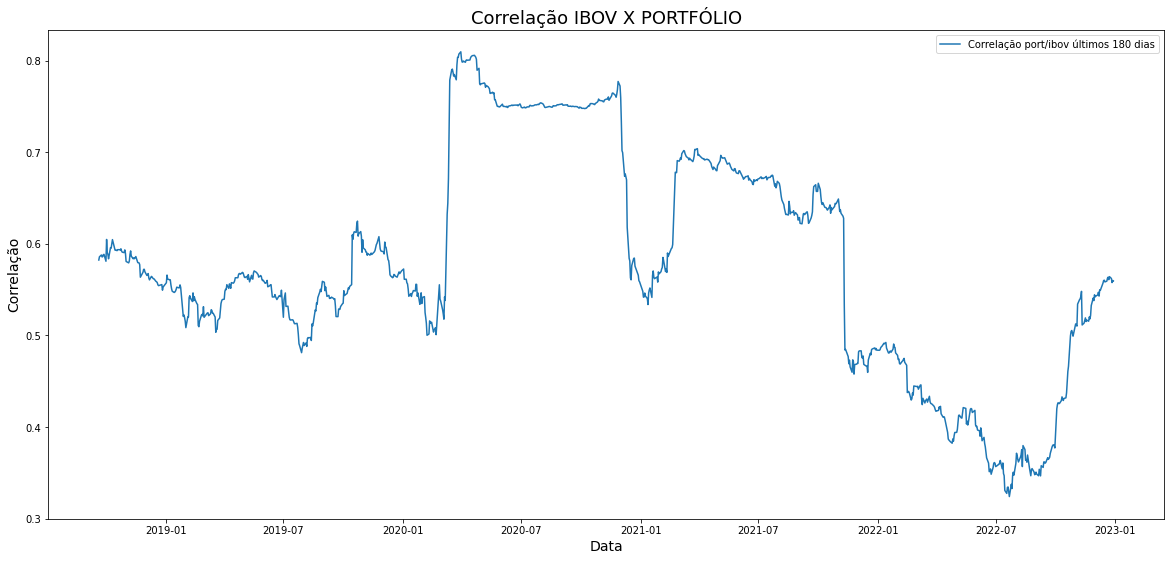

In [15]:
fig8 = plt.figure(figsize = (20,9))

plt.plot(port_ibov['Ibovespa'].rolling(180).corr(port_ibov.iloc[:,1]), label = "Correlação port/ibov últimos 180 dias")
plt.legend()
plt.title('Correlação IBOV X PORTFÓLIO', fontsize = 18)
plt.ylabel('Correlação',
           fontsize = 14)
plt.xlabel("Data",
           fontsize = 14)
plt.savefig('Correlação IBOV X PORTFÓLIO - 180 dias', dpi = 200)

Gráfico 8

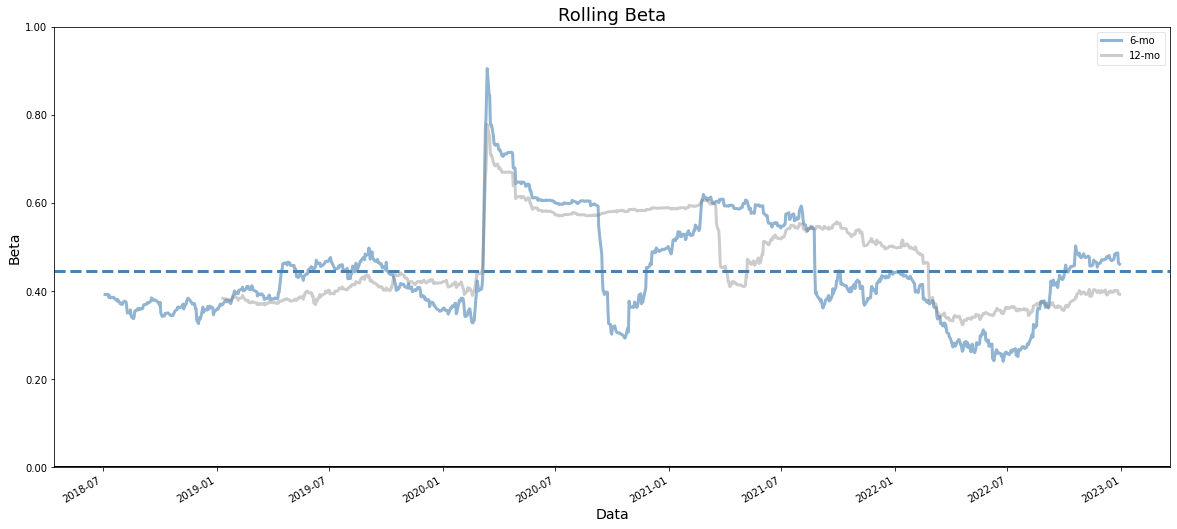

In [16]:
fig9 = plt.figure(figsize = (20,9))

pf.plot_rolling_beta(port_ibov['Portifólio'], port_ibov['Ibovespa'])
plt.ylabel('Beta',
           fontsize = 14)
plt.xlabel("Data",
           fontsize = 14)
plt.title('Rolling Beta',
          fontsize = 18)
plt.ylim(0,1)
plt.savefig('Rolling Beta', dpi = 200)

Gráfico 9

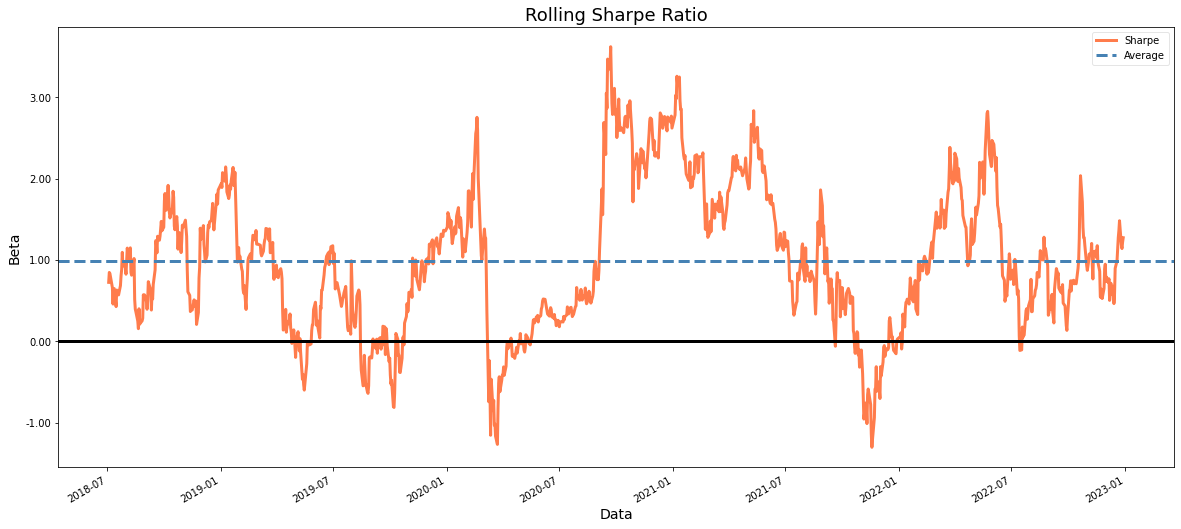

In [17]:
fig10 = plt.figure(figsize = (20,9))

pf.plot_rolling_sharpe(port_ibov['Portifólio'])

plt.title('Rolling Sharpe Ratio',
          fontsize = 18)
plt.ylabel('Beta',
           fontsize = 14)
plt.xlabel("Data",
           fontsize = 14)

plt.savefig('Rolling Sharpe Ratio', dpi = 200)

Gráfico 10

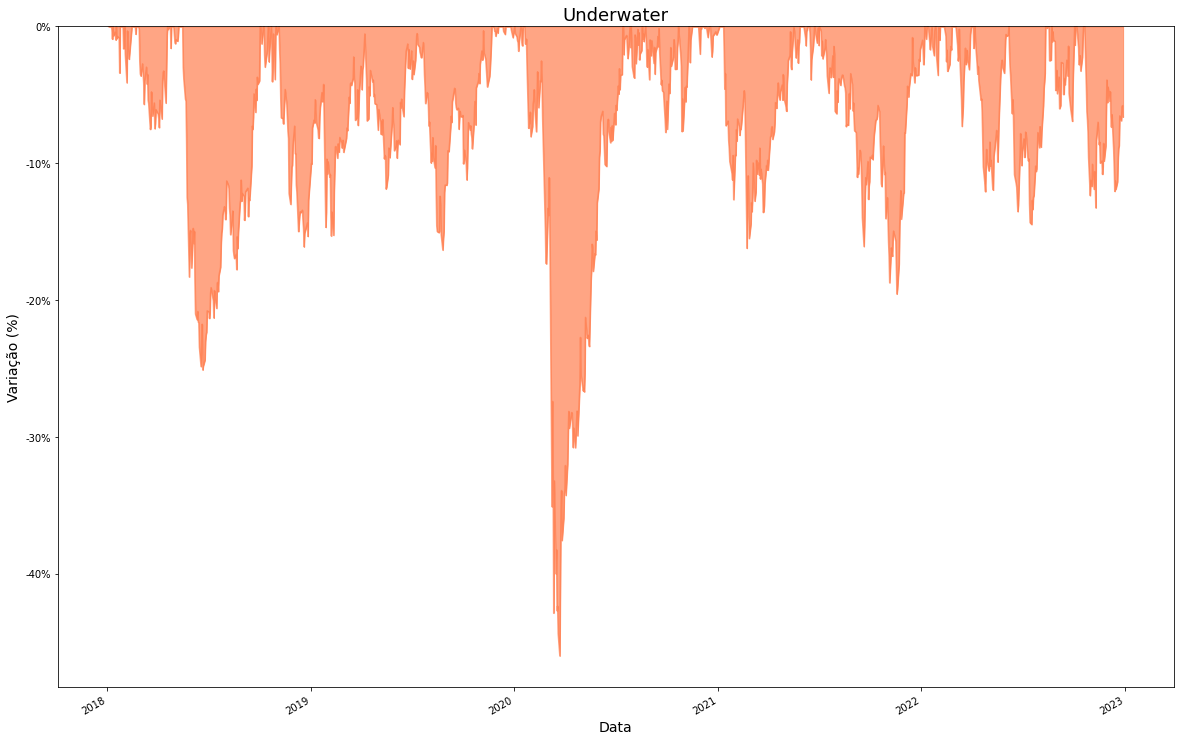

In [18]:
fig11 = plt.figure(figsize = (20,13.5))

pf.plot_drawdown_underwater(port_ibov['Portifólio']);

plt.title('Underwater',
          fontsize = 18)
plt.ylabel('Variação (%)',
           fontsize = 14)
plt.xlabel("Data",
           fontsize = 14)

plt.savefig('Underwater', dpi = 200)

Gráfico 11

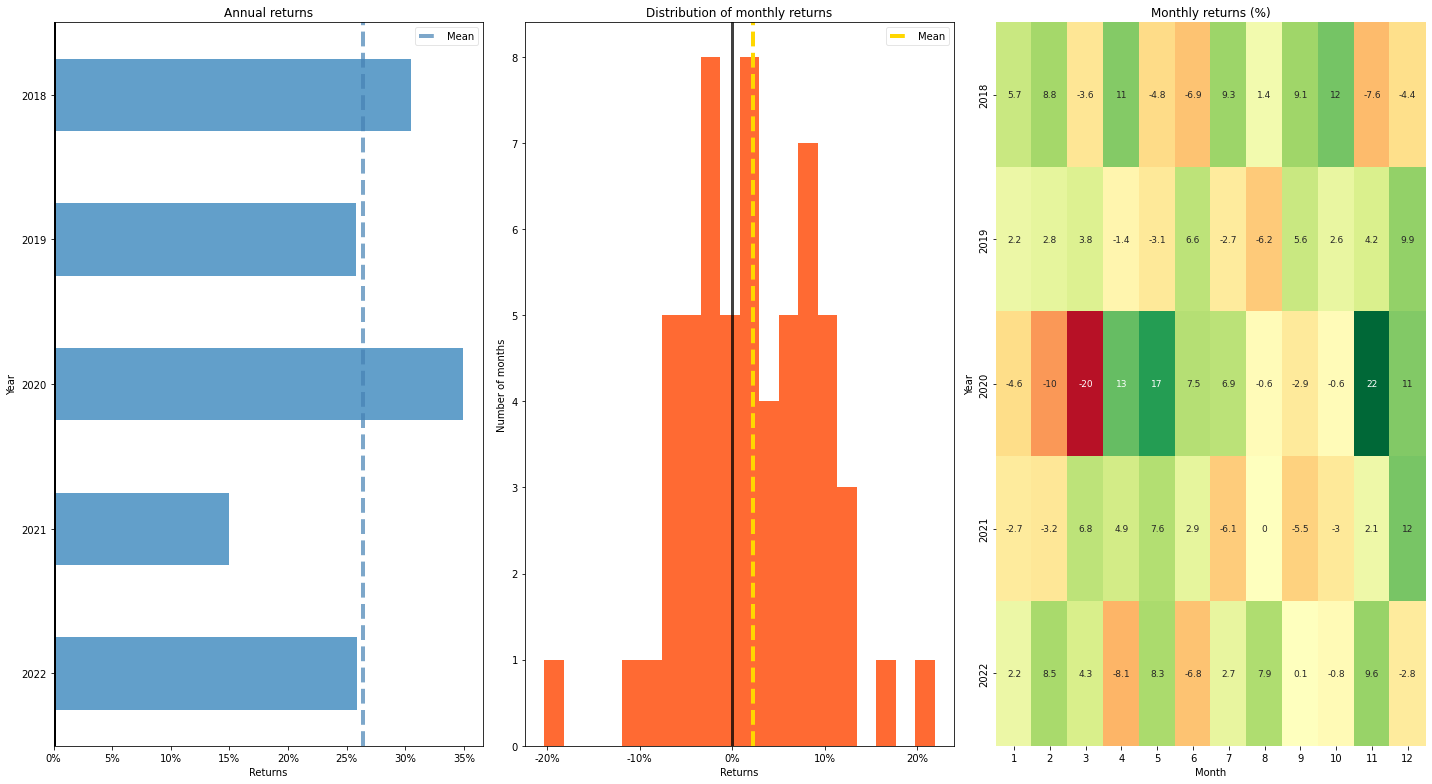

In [19]:
fig12 = plt.figure(1, figsize = (20,11))
plt.subplot(1,3,1)
pf.plot_annual_returns(port_ibov['Portifólio'])
plt.subplot(1,3,2)
pf.plot_monthly_returns_dist(port_ibov['Portifólio'])
plt.subplot(1,3,3)
pf.plot_monthly_returns_heatmap(port_ibov['Portifólio'])
plt.tight_layout()
fig.set_size_inches(30,10)

plt.savefig('Retornos.png', dpi = 200)

Monte Carlo

In [20]:
drift = np.array(dados['Retorno'].mean() - dados['Retorno'].var()/2)
std = np.array(dados['Retorno'].std())
t_intervalo = 360
iteracao = 100
retorno_diario = np.exp(drift + std * norm.ppf(np.random.rand(t_intervalo, iteracao)))
port_valores = pd.DataFrame(np.dot(dados.iloc[: , 1 : len(acoes) + 1], pesos.T))
s0 = port_valores.iloc[-1]
preco_lista = np.zeros_like(retorno_diario)
preco_lista[0] = s0
for t in range(1, t_intervalo):
    preco_lista[t] = preco_lista[t - 1] * retorno_diario[t]
preco_lista = pd.DataFrame(preco_lista)
columnames = []
for i in range(iteracao):
  columnames.append('simulação {}'.format(i+1))
preco_lista.columns = columnames
port_mc = preco_lista/preco_lista.iloc[0]
melhores_piores_desemp = port_mc.iloc[-1].sort_values()
carteira_mc = pd.DataFrame()
carteira_mc['Pior carteira'] = port_mc[melhores_piores_desemp.index[0]]
carteira_mc['Melhor carteira'] = port_mc[melhores_piores_desemp.index[iteracao-1]] 
carteira_mc['Carteira mediana'] = port_mc[melhores_piores_desemp.index[iteracao-int(iteracao/2)]]



Gráfico Monte Carlo 1


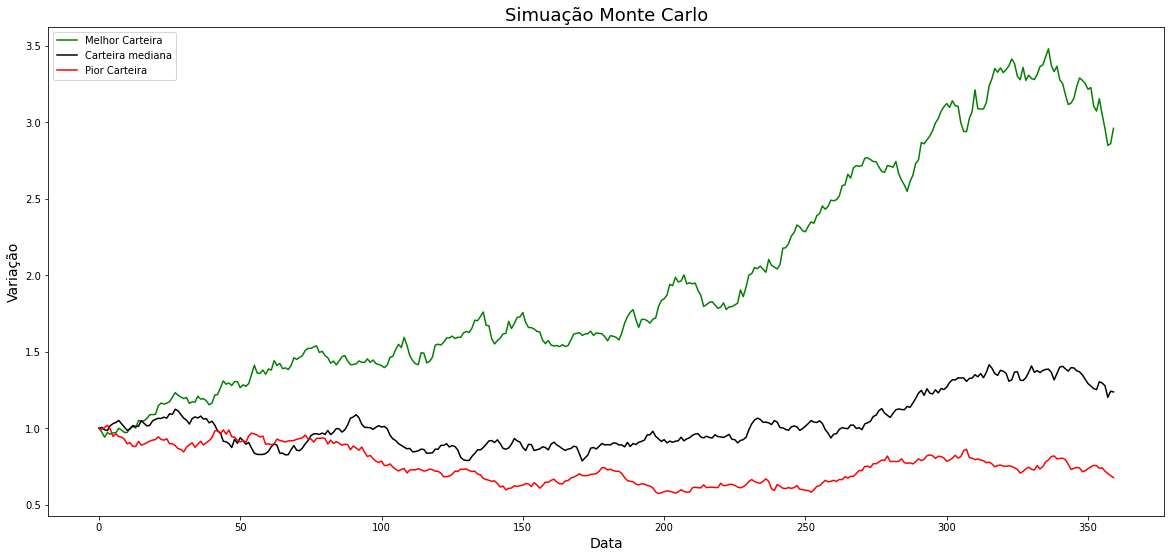

In [21]:
fig13 = plt.figure(1, figsize = (20,9))

plt.title('Simuação Monte Carlo',
          fontsize = 18)
plt.ylabel('Variação',
           fontsize = 14)
plt.xlabel("Data",
           fontsize = 14)


plt.plot(carteira_mc['Melhor carteira'], label = 'Melhor Carteira', color = 'green')
plt.plot(carteira_mc['Carteira mediana'], label = 'Carteira mediana', color = 'black')
plt.plot(carteira_mc['Pior carteira'], label = 'Pior Carteira', color = 'red')
plt.legend()
plt.savefig('Monte_Carlo1.png', dpi = 200)

Gráfico Monte Carlo 2

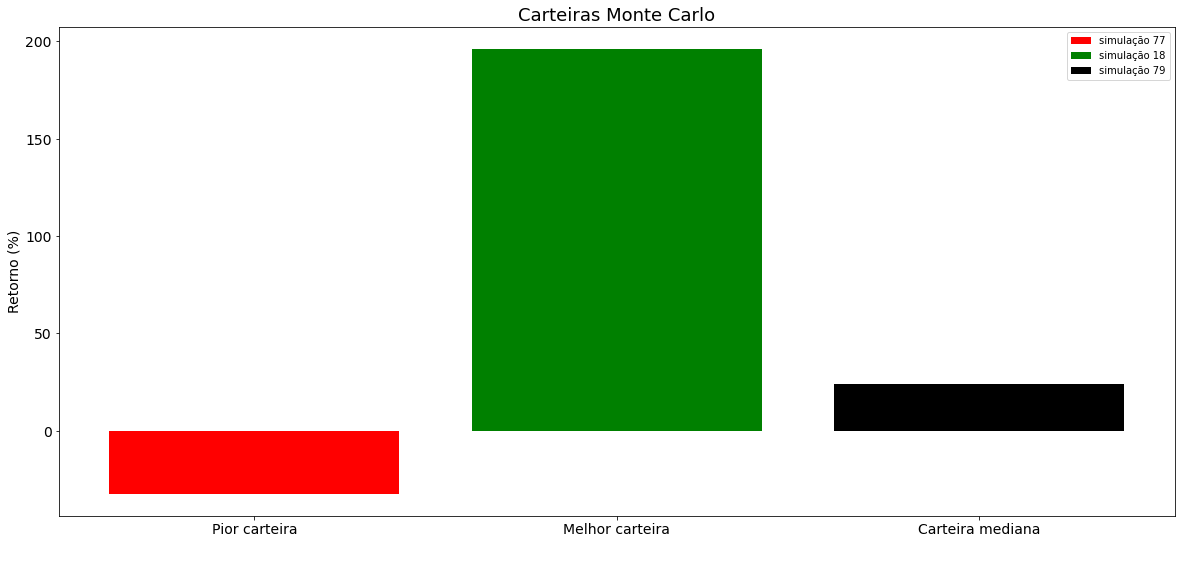

In [22]:
fig14 = plt.figure(1, figsize = (20,9))

plt.bar('Pior carteira', list(carteira_mc.iloc[ -1 , :] - 1)[0] * 100, label = melhores_piores_desemp.index[0], color = 'red')
plt.bar('Melhor carteira', list(carteira_mc.iloc[ -1 , :] - 1)[1] * 100, label = melhores_piores_desemp.index[iteracao-1], color = 'green')
plt.bar('Carteira mediana', list(carteira_mc.iloc[ -1 , :] - 1)[2] * 100, label = melhores_piores_desemp.index[iteracao-int(iteracao/2)], color = 'black')

plt.title('Carteiras Monte Carlo',
          fontsize = 18)
plt.ylabel('Retorno (%)',
           fontsize = 14)
plt.xlabel('  ',
           fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend()

plt.savefig('Monte_Carlo2.png', dpi = 200)

VAR

In [23]:
alpha = 0.05
media_retorno = port_ibov['Portifólio'].mean()
std = port_ibov['Portifólio'].std()

var = norm.ppf(alpha, media_retorno, std)

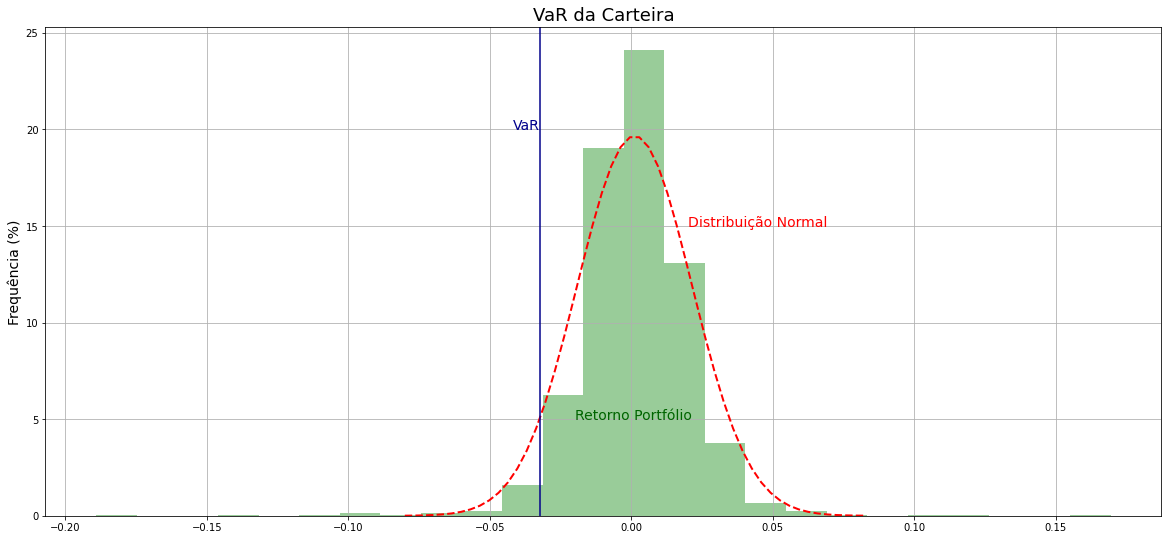

In [24]:
fig15 = plt.figure(1, figsize = (20,9))

plt.title('VaR da Carteira',
          fontsize = 18)
plt.ylabel('Frequência (%)',
           fontsize = 14)
plt.xlabel('  ',
           fontsize = 14)

port_ibov['Portifólio'].hist(bins=25, density=True, alpha=0.4, color='green');

x = np.linspace((media_retorno - 4*std), (media_retorno + 4*std), 50)
plt.plot(x, norm.pdf(x, media_retorno, std), 'r--', lw=2)

plt.axvline(x=var, color = 'darkblue')

plt.text(0.02, 15, 'Distribuição Normal', fontsize=14, color='red')
plt.text(-0.02, 5, 'Retorno Portfólio', fontsize=14, color='darkgreen')
plt.text(-0.042, 20, 'VaR', fontsize=14, color='darkblue')


plt.savefig('VAR.png', dpi = 200)

PDF

In [26]:
width = 210
height = 297

# 1. Setup PDF
pdf = FPDF()
#PAGE 1 
pdf.add_page()
pdf.image('topo.png', 0, 0, width)
pdf.image('barra.png', 40, height/2-30, 5)
pdf.set_font('Arial', 'B', 40)

pdf.cell(40)
pdf.cell(0, 240, 'RELATÓRIO', 0, 0, 'L')

pdf.ln(20)
pdf.cell(40)
pdf.cell(0, 240, 'CARTEIRA', 0, 0, 'L')
pdf.set_font('Arial','' ,15)

pdf.image('rodape_git.png', 0,height-18,width, 
          link = 'https://github.com/joelsoaresjr')


#PAGE 2
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.cell(10, 10, f'Relatório Carteira: {nome} - {hoje.day}/{hoje.month}/{hoje.year}')
pdf.image('Fronteira Eficiente de Markowitz.png', 0, 17, width)
pdf.image('Mín Variância x Sharpe Ratio.png', 0, 102, width)
pdf.image('Ações e Ibov.png', 0, 188, width)
pdf.image('rodape_git.png', 0,height-18,width, 
          link = 'https://github.com/joelsoaresjr')


#PAGE 3
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.cell(40, 10, f'Relatório Carteira: {nome} - {hoje.day}/{hoje.month}/{hoje.year}')
pdf.image('Portfólio X Ibov.png', 0, 17, width)
pdf.image('Volatilidade do portfólio em períodos.png', 0, 102, width/2)
pdf.image('Ibovespa x Portfólio - comparação.png', width/2, 102, width/2)
pdf.image('Correlação entre Ibov e carteira.png', 0, 188, width/2)
pdf.image('Correlação entre cada ativo.png', width/2, 188, width/2)
pdf.image('rodape_git.png', 0,height-18,width, 
          link = 'https://github.com/joelsoaresjr')

#PAGE 4
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.cell(40, 10, f'Relatório Carteira: {nome} - {hoje.day}/{hoje.month}/{hoje.year}')
pdf.image('Correlação IBOV X PORTFÓLIO - 180 dias.png', 0, 17, width)
pdf.image('Rolling Beta.png', 0, 102, width)
pdf.image('Rolling Sharpe Ratio.png', 0, 188, width)
pdf.image('rodape_git.png', 0,height-18,width, 
          link = 'https://github.com/joelsoaresjr')

#PAGE 5
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.cell(40, 10, f'Relatório Carteira: {nome} - {hoje.day}/{hoje.month}/{hoje.year}')
pdf.image('Underwater.png', 0, 17, width)
pdf.image('Retornos.png', 0, 150, width)
pdf.image('rodape_git.png', 0,height-18,width, 
          link = 'https://github.com/joelsoaresjr')

#PAGE 6
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.cell(40, 10, f'Relatório Carteira: {nome} - {hoje.day}/{hoje.month}/{hoje.year}')
pdf.image('VAR.png', 0, 17, width)
pdf.image('Monte_Carlo2.png', 0, 102, width)
pdf.image('Monte_Carlo1.png', 0, 188, width)
pdf.image('rodape_git.png', 0,height-18,width, 
          link = 'https://github.com/joelsoaresjr')


# 3. Output PDF
pdf.output('Relatório_Carteira.pdf', 'F')


''

Enviar Email

In [27]:
smtp_port = 587                 
smtp_server = "smtp.gmail.com"  

email_from = "relatorio.carteira@gmail.com"
email_list = ["joelsoares33@hotmail.com"]

pswd = "ffzbwumhzblobhmj"


subject = "Seu Relátório de Carteira de Ações Chegou!"


In [30]:
def send_emails(email_list):

    for i in email_list:

        
        corpo = f'Olá, {nome}! \n\n Seu relatório está pronto!'

        
        msg = MIMEMultipart()
        msg['From'] = email_from
        msg['To'] = i
        msg['Subject'] = subject

        
        msg.attach(MIMEText(corpo, 'plain'))

        
        filename = 'Relatório_Carteira.pdf'

        
        attachment= open(filename, 'rb')  

        attachment_package = MIMEBase('application', 'octet-stream')
        attachment_package.set_payload((attachment).read())
        encoders.encode_base64(attachment_package)
        attachment_package.add_header('Content-Disposition', "attachment", filename = 'Relatorio.pdf')
        msg.attach(attachment_package)

        
        text = msg.as_string()

        
        print("Conectanto ao servidor...")
        TIE_server = smtplib.SMTP(smtp_server, smtp_port)
        TIE_server.starttls()
        TIE_server.login(email_from, pswd)
        print("Conectado com sucesso")
        print()


        print(f"Enviando email para: {i}...")
        TIE_server.sendmail(email_from, i, text)
        print(f"Enviando email para: {i}")
        print()

   
    TIE_server.quit()


In [ ]:
send_emails(email_list)

Conectanto ao servidor...
Conectado com sucesso

Enviando email para: joelsoares33@hotmail.com...
